<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/fmottes/unito-neural-networks/blob/master/02%20-%20Fully%20Connected%20Feedforward%20Networks%20with%20TensorFlow.ipynb">
      <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="width:175px;"/>
    </a>
  </td>
</table>

# <center> **Neural Networks** (MFN0824) </center>

### Lectures: _Dr. Matteo Osella_
### Notebooks: _Francesco Mottes_
<br>

---

The reference book for the practical part of this course is:
- *Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow - A. Géron*

There is also a [github page](https://github.com/ageron/handson-ml2) where you can find some notebooks with the code from the book, a good place to start if you want to look into more advanced topics.

**NOTE:** You can easily (and legally) find online a raw and unedited version of the second edition of the book, released by the author before the book was finished. Be advised that, besides not being the revised version, **it is not even the whole book**.

If you want to play with a dense feedforward artificial neural network without writing any code and with a nice visualization, you can try out the Tensorflow Playground (link in the section below).

### References:
- Numpy Docs: https://numpy.org/doc/1.18/
- Matplotlib Docs: https://matplotlib.org/
- Scikit-learn Docs: https://scikit-learn.org/
- Keras Docs: https://keras.io/api/
- Tensorflow Playground: https://playground.tensorflow.org/

# <center> **04 - Convolutional Neural Networks with TensorFlow** </center>

In this notebook we will show ho convolutional layers can be implemented using Keras and Tensorflow. We will implement a simple convolutional block, the famous LeNet architecture and some more advanced topics as Inception and modules. We will also show ho transfer learning can be implemented in Keras, using famous pre-trained models.

In [1]:
#standard imports
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow and keras
import tensorflow as tf
from tensorflow import keras


#function for fast generation of training and test set from data
from sklearn.model_selection import train_test_split

In [2]:
# check tensorflow and keras versions
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


## <center> **Loading MNIST** </center>

In this section we load the MNIST dataset into the notebook, in the same in which we loaded it in the preceding notebook.

In [3]:
from tensorflow.keras.datasets import mnist

#load actual data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

The MNIST dataset contains hand-written, single digits in the range 0-9, together with their correct classification. Digits are stored as grayscale images with size 28x28 pixels, represented as Numpy arrays of shape (28,28) and entries in the range 0-255.

As for datasets loaded through scikit-learn, also in this case a division into training set and test set is already provided: 60000 images are loaded as training samples and 10000 as test sample. Note that, in order to have a sound machine learning pipeline, we will also need to build ourselves a validation set.

In [4]:
#check shape of the training set
print('TRAINING SET:\t',X_train.shape)

#check shape of the test set
print('TEST SET:\t', X_test.shape)

TRAINING SET:	 (60000, 28, 28)
TEST SET:	 (10000, 28, 28)


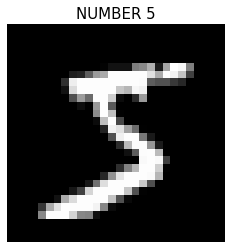

In [5]:
#show first image contained in the training data, with its label

plt.imshow(X_train[0], cmap='gray')
plt.title('NUMBER {}'.format(y_train[0]), fontsize=15)
plt.axis('off'); #do not show spines

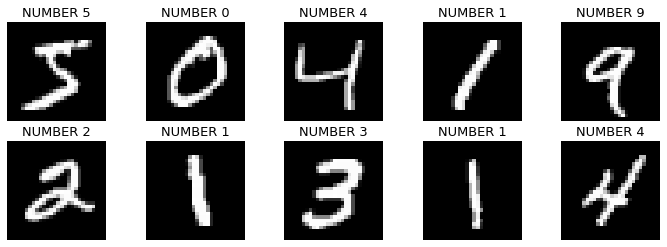

In [6]:
# show the first 10 images in the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title('NUMBER {}'.format(y_train[i]), fontsize=13)
    ax.axis('off')

Note that the classes in the dataset are not balanced. This is usually something you want to take into account when training a machine learning algorithm, either by balancing classes by eliminating some samples from the most populated ones or by means of more sophisticated techniques. Since this problem is not a real issue for this dataset and is not an argument strictly connected with ANNs we will not address it here.

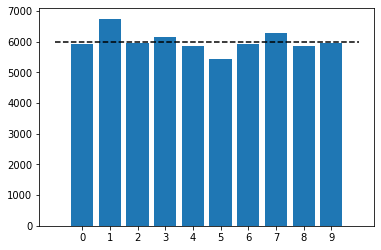

In [7]:
plt.hlines(6000, -1, 10, linestyles='--')

plt.hist(y_train, bins=np.linspace(-.5,9.5,11), rwidth=.8)
plt.xticks(range(10));

We now need to split the training set into training and validation set:

In [8]:
val_size = .1 #use 6000 samples as validation set

#generate training and test set with stratification
#this means that we will find the same proportion of classes bot in the validation and in the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train)

And finally transform the data in a format more suitable for use in training a neural network:

In [9]:
#rescale pixel values to the range (0,1)
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [10]:
#transform integer label into one-hot encodings
n_classes=10

y_train_cat = keras.utils.to_categorical(y_train, n_classes)
y_val_cat = keras.utils.to_categorical(y_val, n_classes)
y_test_cat = keras.utils.to_categorical(y_test, n_classes)

## <center> **Simple CNN with the Keras Functional API** </center>

Most of the following models can be constructed easily also using the Sequential API, but we will need the more powerful Functional API to build more complex modules, such as Inception. The "classical" version of the convuolutional module is the one depicted below: a series of *feature maps* (also sometimes called *channels*) built by the convolutional layer, followed by a pooling layer which is then serialized into a flat vector and fed to a fully connected neural network.

![Classical convolutional module](img/convolutional_module.png)

Below you find the implementation of this simple module, with arbitrary values for the hyperparameters.

In [12]:
#a few more imports for readability

#import generic model class
from tensorflow.keras import Model, Input

#import the types of layes we need
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Reshape

In [58]:
#very important! do it before you instantiate a brand new model
#cleares the backend of all the previous instances of the models 
#which might interfere with the new instance
keras.backend.clear_session()


#we intend to pass as inputs images of shape 28x28 with only one channel
#convolutional layers need to have the number of input channels explicitely specified
inputs = Input(shape=(28,28)) 
x = Reshape(target_shape=(28,28,1))(inputs)

#we now apply to the inputs a convolutional layer with the shown parameters
#padding='same' means kears will pad the image with an adequate number of zeros, so that
#the shape of the feature maps will be 28x28 after the convolution
x = Conv2D(filters=6, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu')(x)

#add a pooling layer
#padding='valid' means no padding will happen and the feature maps will be smaller than the input
x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#flatten the feature maps
x = Flatten()(x)

#add a hidden dense layer
x = Dense(15, activation='tanh')(x)

#output layer with softmax for classification
outputs = Dense(n_classes, activation='softmax')(x)


#build model
#NOTE: when building the network in this way, keras only needs tha inputs and the outputs of the model:
#it will automatically reconstruct all of the dependencies that we declared before!
model = Model(inputs=inputs, outputs=outputs, name='basic_convolution')

In [59]:
#we can now print a summary of the model we created

model.summary()

Model: "basic_onvolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1176)              0         
_________________________________________________________________
dense (Dense)                (None, 15)                17655     
_________________________________________________________________
dense_1 (Dense)              (None, 10)           

**Notice** the huge difference in the number of parameters between the convolutional and the fully connected layer!

Now we need to specify the optimizer, the loss function and the metrics to keep track of.

In [60]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Now we are ready to train the network on the MNIST dataset:

In [61]:
#define some hyperparameters

epochs = 15
batch_size = 128

In [62]:
history = model.fit(
    X_train,
    y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val,y_val_cat),
    verbose=1 #default, show progress bar
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 36s 658us/sample - loss: 1.3108 - accuracy: 0.6745 - val_loss: 0.8185 - val_accuracy: 0.8170
Epoch 2/15
54000/54000 [==============================] - 31s 582us/sample - loss: 0.6855 - accuracy: 0.8507 - val_loss: 0.5751 - val_accuracy: 0.8772
Epoch 3/15
54000/54000 [==============================] - 31s 583us/sample - loss: 0.5268 - accuracy: 0.8806 - val_loss: 0.4716 - val_accuracy: 0.8925
Epoch 4/15
54000/54000 [==============================] - 40s 746us/sample - loss: 0.4465 - accuracy: 0.8941 - val_loss: 0.4088 - val_accuracy: 0.9045
Epoch 5/15
54000/54000 [==============================] - 38s 699us/sample - loss: 0.3960 - accuracy: 0.9036 - val_loss: 0.3674 - val_accuracy: 0.9087
Epoch 6/15
54000/54000 [==============================] - 37s 694us/sample - loss: 0.3596 - accuracy: 0.9103 - val_loss: 0.3354 - val_accuracy: 0.9142
Epoch 7/15
54000/54000 [=====================

**Note:** If you want to re-train the network from scratch after this step, you will have to call the *clear_backend()* function and re-define the whole network. Every model internally stores the state of the training at which it was stopped, if you don't clear it training will be taken up from where it was stopped before.

We can now evaluate the trained model on the test set and use it to generate predictions for new data.

In [63]:
#evaluate model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

10000/10000 [==============================] - 2s 246us/sample - loss: 0.1911 - accuracy: 0.9515

Test Loss:	 0.19112833923101424
Test Accuracy:	 0.9515


Using the data contained in the history dictionary we can construct the **learning curves** associated with the training of our model.

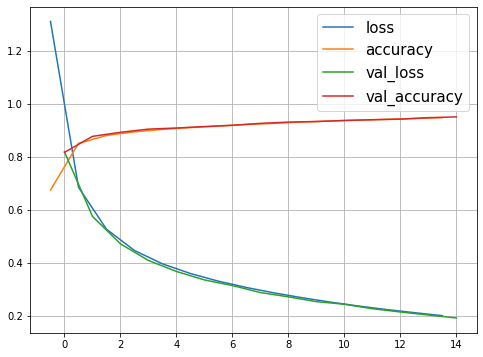

In [64]:
#plot learning curves

fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    
    #subtract half epoch from training data
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch)-.5, history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid()    

ax.legend(fontsize=15);

We can also visualize the wrong predictions, in order to understand where the model fails.

In [65]:
#identify wrong predictions in the training set

y_train_pred = model.predict(X_train).argmax(axis=1)

idx_wrong = np.where(y_train_pred != y_train)[0] #positions of the wrongly classified data

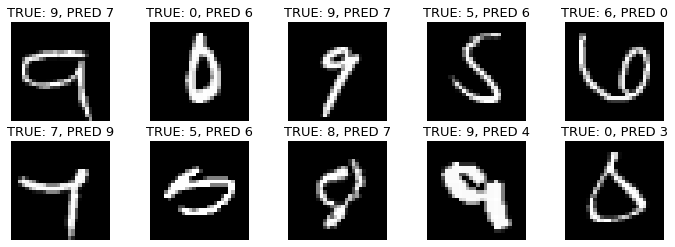

In [66]:
# show the first 10 wrong predictions the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    idx = idx_wrong[i]
    
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title('TRUE: {}, PRED {}'.format(y_train[idx], y_train_pred[idx]), fontsize=13)
    ax.axis('off')

**NOTE:** You can compare the results obtained with this basic CNN with those obtained in the notebook on feed-forward networks. Despite having the same number of neurons in the hidden layer and a comparable number of parameters, the CNN reaches a test accuracy of 95% after only 15 epochs of training, while the dense network reached 92.5% after 30 epochs!

## <center> **LeNet-5 (1998)** </center>

We now show how to implement the first famous CNN architecture - LeNet-5 - that was implemented precisely with the purpose of recognizing hand-written digits.

Here you have a graphical representation of the architecture, note that the input image is considered to be 32x32 because of the *same* padding.

![Architecture of LeNet-5](img/LeNet-5.png)

The implementation in keras is straightforward:

In [67]:
from tensorflow.keras.layers import AvgPool2D

In [81]:
#very important! do it before you instantiate a brand new model
#cleares the backend of all the previous instances of the models 
#which might interfere with the new instance
keras.backend.clear_session()


#we intend to pass as inputs images of shape 28x28 with only one channel
#convolutional layers need to have the number of input channels explicitely specified
inputs = Input(shape=(28,28)) 
x = Reshape(target_shape=(28,28,1))(inputs)

#C1
x = Conv2D(filters=6, kernel_size=(5,5), padding='same', strides=(1,1), activation='tanh')(x)

#S2
x = AvgPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#C3
x = Conv2D(filters=16, kernel_size=(5,5), padding='valid', strides=(1,1), activation='tanh')(x)

#S4
x = AvgPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#C5
x = Conv2D(filters=120, kernel_size=(5,5), padding='valid', strides=(1,1), activation='tanh')(x)


#flatten the feature maps
x = Flatten()(x)

#F6
x = Dense(84, activation='tanh')(x)

#output layer with softmax for classification
outputs = Dense(n_classes, activation='softmax')(x)


#build model
#NOTE: when building the network in this way, keras only needs tha inputs and the outputs of the model:
#it will automatically reconstruct all of the dependencies that we declared before!
lenet5 = Model(inputs=inputs, outputs=outputs, name='LeNet-5')

In [82]:
#we can now print a summary of the model we created

lenet5.summary()

Model: "LeNet-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)         4812

**NOTE:** The actual implementation of the original LeNet-5 was a bit different in some details, such as a slightly different implementation of average pooling, the output of the last layer and connection between the S2 and C3 layers. Nonetheless, the main design of the architecture is exactly the same. You can look at our implementation as a modernized version of LeNet-5.

In [83]:
lenet5.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Now we are ready to train the network on the MNIST dataset:

In [84]:
#define some hyperparameters

epochs = 15
batch_size = 128

In [85]:
history = lenet5.fit(
    X_train,
    y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val,y_val_cat),
    verbose=1 #default, show progress bar
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 50s 927us/sample - loss: 1.4207 - accuracy: 0.6599 - val_loss: 0.6570 - val_accuracy: 0.8432
Epoch 2/15
54000/54000 [==============================] - 51s 952us/sample - loss: 0.5242 - accuracy: 0.8658 - val_loss: 0.4340 - val_accuracy: 0.8832
Epoch 3/15
54000/54000 [==============================] - 48s 896us/sample - loss: 0.4000 - accuracy: 0.8899 - val_loss: 0.3633 - val_accuracy: 0.8985
Epoch 4/15
54000/54000 [==============================] - 43s 798us/sample - loss: 0.3469 - accuracy: 0.9012 - val_loss: 0.3231 - val_accuracy: 0.9073
Epoch 5/15
54000/54000 [==============================] - 48s 895us/sample - loss: 0.3129 - accuracy: 0.9101 - val_loss: 0.2939 - val_accuracy: 0.9165
Epoch 6/15
54000/54000 [==============================] - 50s 932us/sample - loss: 0.2872 - accuracy: 0.9178 - val_loss: 0.2714 - val_accuracy: 0.9220
Epoch 7/15
54000/54000 [=====================

We can now evaluate the trained model on the test set and use it to generate predictions for new data.

In [86]:
#evaluate model on the test set
test_loss, test_acc = lenet5.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

10000/10000 [==============================] - 3s 258us/sample - loss: 0.1494 - accuracy: 0.9559

Test Loss:	 0.14937702343314885
Test Accuracy:	 0.9559


Using the data contained in the history dictionary we can construct the **learning curves** associated with the training of our model.

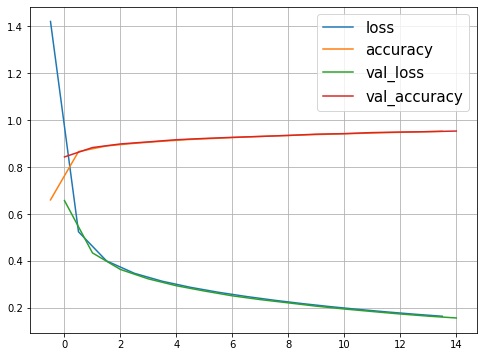

In [87]:
#plot learning curves

fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    
    #subtract half epoch from training data
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch)-.5, history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid()    

ax.legend(fontsize=15);

We can also visualize the wrong predictions, in order to understand where the model fails.

In [88]:
#identify wrong predictions in the training set

y_train_pred = lenet5.predict(X_train).argmax(axis=1)

idx_wrong = np.where(y_train_pred != y_train)[0] #positions of the wrongly classified data

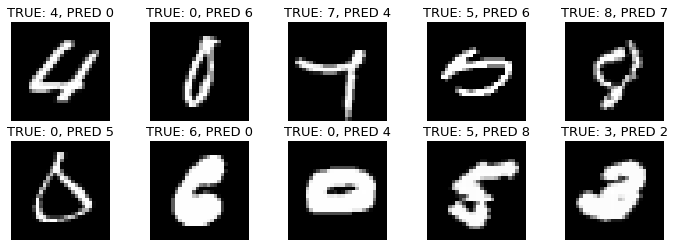

In [89]:
# show the first 10 wrong predictions the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    idx = idx_wrong[i]
    
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title('TRUE: {}, PRED {}'.format(y_train[idx], y_train_pred[idx]), fontsize=13)
    ax.axis('off')

## <center> **The Inception Module** </center>

The core idea behind the Inception module is that we dont really need to choose which is the right dimension of the convolutional filter to apply at a given depth. We can try a bunch of filters with different dimensions and concatenate the results, so that the next step in the network will choose on its own the ones that are most useful. In order to reduce the computational effort, 1x1 convolutions are added before the 3x3 and 5x5 convolutions and after the max pooling. The main effect of 1x1 convolutions is to collapse all the channels into a single one, thus limiting the number of operations to be carried out with larger and heavier filters.

Below you can find a representation of the Inception module:

![The Inception Module](img/inception_module.png)

As you can see there are different computations to be done in parallel, processing the same input. This is clearly not implementable with the Sequential API and it is where the additional flexibility given by the Functional API comes in handy.

In [20]:
from tensorflow.keras.layers import concatenate

#this function accepts as input the output of a preceding layer (or the original data) and
#returns the output of the inception module
#as we have seen, this is all the Functional API needs to know to build a model

#the names of variables are to be interpreted as, for example:
#c3_1 = number of channels for the 3x3 column, 1x1 convolution block
def inception_block(inputs, c1, c3_1, c3_3, c5_1, c5_5, cMP_1):
    
    #1x1
    conv1 = Conv2D(c1, kernel_size=(1,1), padding='same', activation='relu')(inputs)

    #3x3
    conv3 = Conv2D(c3_1, kernel_size=(1,1), padding='same', activation='relu')(inputs)
    conv3 = Conv2D(c3_3, kernel_size=(3,3), padding='same', activation='relu')(conv3)
    
    #5x5
    conv5 = Conv2D(c5_1, kernel_size=(1,1), padding='same', activation='relu')(inputs)
    conv5 = Conv2D(c5_5, kernel_size=(5,5), padding='same', activation='relu')(conv5)
    
    #max pooling
    max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
    max_pool = Conv2D(cMP_1, kernel_size=(1,1), padding='same', activation='relu')(max_pool)
    
    #concatenate all the output feature maps
    out = concatenate([conv1,conv3,conv5,max_pool])
    
    return out

We build a network with a couple of inception modules only to show how this should work.

In [133]:
#very important! do it before you instantiate a brand new model
#cleares the backend of all the previous instances of the models 
#which might interfere with the new instance
keras.backend.clear_session()

#inputs
inputs = Input(shape=(28,28)) 
x = Reshape(target_shape=(28,28,1))(inputs)

# small inception block (random numbers of channels)
x = inception_block(x, 16, 8, 32, 4, 8, 8)

# 1x1 convolution to collapse channels
x = Conv2D(3, kernel_size=(1,1), padding='same', activation='relu')(x)

#flatten feature maps
x = Flatten()(x)

#output layer
out = Dense(n_classes, activation='softmax')(x)

inception_model = Model(inputs=inputs, outputs=out, name='inception_model')

In [134]:
inception_model.summary()

Model: "inception_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 8)    16          reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 4)    8           reshape[0][0]                    
____________________________________________________________________________________

In [135]:
inception_model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Now we are ready to train the network on the MNIST dataset:

In [136]:
#define some hyperparameters

epochs = 3 #train only for few epochs, as a demonstration
batch_size = 128

In [137]:
history = inception_model.fit(
    X_train,
    y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val,y_val_cat),
    verbose=1 #default, show progress bar
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 131s 2ms/sample - loss: 1.7615 - accuracy: 0.4071 - val_loss: 0.4409 - val_accuracy: 0.8748
Epoch 2/3
54000/54000 [==============================] - 132s 2ms/sample - loss: 0.3804 - accuracy: 0.8903 - val_loss: 0.3312 - val_accuracy: 0.9043
Epoch 3/3
54000/54000 [==============================] - 129s 2ms/sample - loss: 0.3377 - accuracy: 0.9024 - val_loss: 0.3145 - val_accuracy: 0.9118


We can now evaluate the trained model on the test set and use it to generate predictions for new data.

In [138]:
#evaluate model on the test set
test_loss, test_acc = inception_model.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

10000/10000 [==============================] - 6s 642us/sample - loss: 0.3099 - accuracy: 0.9129

Test Loss:	 0.30988716877698896
Test Accuracy:	 0.9129


## <center> **Transfer Learning & Fine-tuning** </center>

Training a DL model is usually a time and resource consuming activity, so one does not usually want to start all over again every time. Keras provide a very easy way to save and load complete models (and/or their weights). This is also a useful feature if one wants to use big pre-trained models which would be infeasible to train from scratch (like AlexNet, VGG etc.).

We can adapt big pre-trained models to our needs by re-using their weights. This technique is called **Transfer Learning** and the idea at the base of it is that features learned on one task can be useful to accomplish another task which is similar enough. In practice this means that we keep the feature extraction part of the trained model and we strip off the classifier (usually the last dense layer), substituting it with a classifier more adapt for our new purpose. Then we train our new classifier using the features extracted by the **frozen** pre-trained model. Optionally, at the end of this part we may also un-freeze the pre-trained feature extractor and train the whole new network for some time on the new data with a very small learining rate. This procedure is called **fine-tuning**.

This technique is usually employed when training a new big model from scratch is unfeasible for some reason, most often because of lack of adequate amounts of data and/or computational power.

For the sole purpose of explaining the workflow, we will now load [MobileNetv2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) and use it to recognize digits in MNIST. MobileNetv2 is a pretty deep convolutional architecture (it is composed of 88 layers) and makes quite a heavy use of [Depthwise Separable Convolutions](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728), which were introduced in the *Xception* architecture. It also incorporates Residual Connections and many other bells and whistles that makes the training more efficient. We chose this model, even though it is clearly an overkill for MNIST (and probably not well suited either, classifying dogs' races and handwritten digits are arguably two pretty different things), mainly because it is one of the smallest models that can be dowloaded directly from Keras Applications. The version we will load was trained on the ImageNet dataset, so we can expect that the feature extractor is well suited (even too much) for our purpose.

A longer guide to transfer learning in keras can be found [here](https://keras.io/guides/transfer_learning/).

### Transfer Learning

In [58]:
from tensorflow.keras.layers import ZeroPadding2D, GlobalAveragePooling2D

In [84]:
# load model from keras
mobnet = keras.applications.MobileNetV2(
    weights='imagenet', #pre-trained weights on imagenet
    include_top=False, #strip off dense classifier
    input_shape=(128,128,3) #28x28 images are too small, see next cell
)

9412608/9406464 [==============================] - 3s 0us/step


In [90]:
mobnet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [91]:
keras.backend.clear_session()

#BUILD THE NEW MODEL:

### INPUTS
inputs = Input(shape=(28,28)) 
x = Reshape(target_shape=(28,28,1))(inputs)

#the network expects images with 3 channels and dimension at least 32x32
x = ZeroPadding2D(padding=50)(x)
x = concatenate([x,x,x])

### PRE-TRAINED FEATURE EXTRACTOR

#freeze mobilenet weights
mobnet.trainable = False

#add mobnet to the network only in inference mode (SEE LATER)
x = mobnet(x, training=False)

### CLASSIFIER

#transform feature maps to vector in a smarter way than flattening
x = GlobalAveragePooling2D()(x)

#last dense layer with softmax
outputs = Dense(n_classes, activation='softmax')(x)


### BUILD MODEL
mnist_mobnet = Model(inputs=inputs, outputs=outputs, name='mnist_mobnet')

**NOTE:** There is a subtle difference between the effects of the "trainable" parameter and the "training" vs. "inference" mode in which one model might act. If you are interested, you can find a more detailed description of this difference [here](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).

In [92]:
mnist_mobnet.summary()

Model: "mnist_mobnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 128, 128, 1)  0           reshape[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 3)  0           zero_padding2d[0][0]             
                                                                 zero_padding2d[0][0]  

In [93]:
mnist_mobnet.compile(
    loss='categorical_crossentropy',
    optimizer='adam', #smarter optimizer than vanilla SGD
    metrics=['accuracy']
)

Now we are ready to train the network on the MNIST dataset:

In [94]:
#define some hyperparameters

epochs = 1 #train only for one epoch, as a demonstration
batch_size = 128

In [95]:
history = mnist_mobnet.fit(
    X_train,
    y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val,y_val_cat),
    verbose=1 #default, show progress bar
)

Train on 54000 samples, validate on 6000 samples
54000/54000 [==============================] - 503s 9ms/sample - loss: 0.5482 - accuracy: 0.8427 - val_loss: 0.3056 - val_accuracy: 0.9125


In [96]:
#evaluate loaded model on the test set
test_loss, test_acc = mnist_mobnet.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

10000/10000 [==============================] - 89s 9ms/sample - loss: 0.2961 - accuracy: 0.9163

Test Loss:	 0.29611287813186643
Test Accuracy:	 0.9163


So this model can reach a nice accuracy in only one epoch of training, but evidently can be replaced with much simpler models which will train in a shorter amount of time on this pretty simple task.

### Fine Tuning

For the sake of showing the procedure, we can also take this thing a step further and add a **fine tuning** step to the training. This is done by un-freezing the mnist_mobnet weights and lowering considerably the learning rate to avoid destroying precious information encoded in the feature extractor and also avoid overfitting.

You can find the code you would need to do this, the actual training will not be carried out even for one single epoch sisnce it would take way too much time on a normal laptop.

In [ ]:
#unfreeze the mobnet model's weights
mobnet.trainable = True

#recompile your model after you make any changes to the `trainable` attribute of any inner layer
#your changes will not be taken into account otherwise
mnist_mobnet.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
    metrics=['accuracy']
)


history = mnist_mobnet.fit(
    X_train,
    y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val,y_val_cat),
)

## <center> **Exercises** </center>

### Play with the code 

As always, the best way to understand is to change things and try to understand what happens. In neural networks there surely is not shortage of things you can change and get very different results: activations, loss function, epochs of training, batch size, optimizer, number of layers, number of neurons per layer, ...

### F-MNIST Dataset

You have already encountered the Fashion-MNIST dataset. It has the advantage of being more difficult to learn for a neural network, while retaining the feature that made MNIST so widespread, like small size, abundance of data both for training and testing and being easy to handle. The ten classes in this case are categories of fashion items and clothes, images are 28x28 b/w as is for MNIST.

Classification of this dataset is a task even better suited for a convolutional neural network, since there are more complex features to be learned than the simple ones you can find in digits. 

**Note:** You will need to apply also here the preprocessing steps!

In [33]:
# load FMINST data

from keras.datasets import fashion_mnist

#load actual data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [34]:
#class names are not provided with the data
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

d_class_name = dict(zip(range(10),class_names))

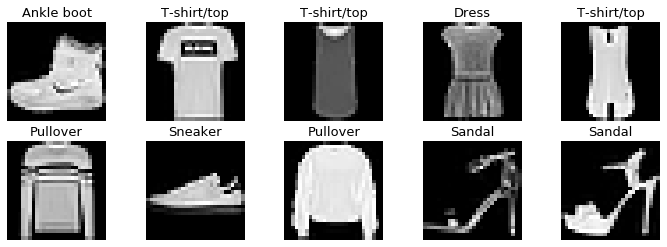

In [35]:
# show the first 10 images in the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title('{}'.format(d_class_name[y_train[i]]), fontsize=13)
    ax.axis('off')

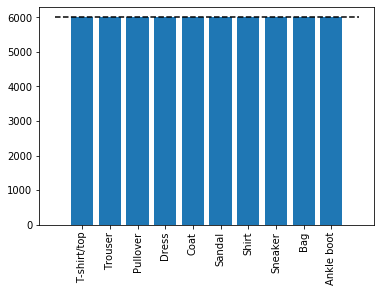

In [36]:
plt.hlines(6000, -1, 10, linestyles='--')

plt.hist(y_train, bins=np.linspace(-.5,9.5,11), rwidth=.8)
plt.xticks(range(10), labels=class_names, rotation=90);

### CIFAR-10 Dataset

The CIFAR-10 dataset takes all of this another step further, featuring 50,000 color images for training and 10,000 for testing. The ten classes in this case are categories of animals or transport means, images are 32x32 RGB, so with three input channels. The size of the images is still manageable, but the extra difficulties of color and more complex features are added. You can find more details [here](https://www.cs.toronto.edu/~kriz/cifar.html).

**Note:** You will need to apply also here the preprocessing steps!

In [98]:
# load CIFAR data

from tensorflow.keras.datasets import cifar10

#load actual data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)

170500096/170498071 [==============================] - 47s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [106]:
y_train = y_train.T[0]
y_test = y_test.T[0]

In [118]:
#class names are not provided with the data
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

d_class_name = dict(zip(range(10),class_names))

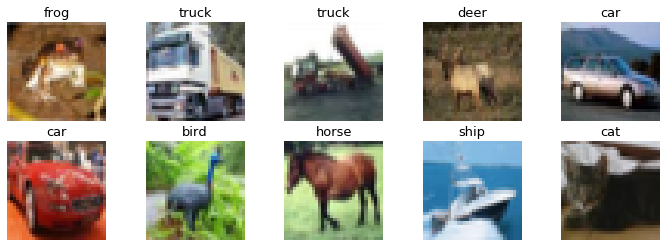

In [119]:
# show the first 10 images in the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title('{}'.format(d_class_name[y_train[i]]), fontsize=13)
    ax.axis('off')

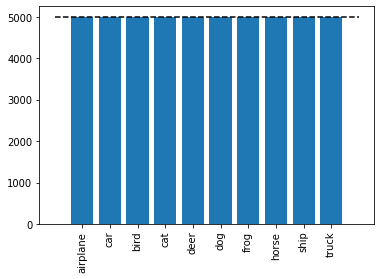

In [120]:
plt.hlines(5000, -1, 10, linestyles='--')

plt.hist(y_train, bins=np.linspace(-.5,9.5,11), rwidth=.8)
plt.xticks(range(10), labels=class_names, rotation=90);